In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict
from pesummary.gw.conversions import convert

In [65]:
plt.rcParams.update({
    "lines.markersize": 6,
    "lines.markeredgewidth": 1.5,
    "lines.linewidth": 3.0,
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 20,
})

In [2]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

## GW190412-like signal

## Read in PSDs, etc

In [3]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

approximant = 'IMRPhenomXPHM'

In [4]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


## Parameters

In [5]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
snr = 18

In [6]:
params = {'mass_1': m1,
          'mass_2': m2,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

## Spin directions

In [7]:
dx_directions = ['spin_1z', 'spin_2z']

In [8]:
g_spin = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [9]:
print(g_spin.dx_directions)
print(g_spin.metric)
print(g_spin.evec)
print(g_spin.evals)

['spin_1z', 'spin_2z']
[[39.23808949  9.0249026 ]
 [ 9.0249026   2.07803438]]
[[ 0.97455536 -0.22414692]
 [ 0.22414692  0.97455536]]
[4.13139742e+01 2.16229045e-03]


In [10]:
spin_ellipse = g_spin.generate_ellipse()

In [11]:
spin_mat = g_spin.generate_match_grid(npts=21, mismatch=g_spin.mismatch*(1.3)**2)
spin_p = np.exp(-snr**2/2 * (1 - spin_mat['match']))

In [12]:
chi1, chi2 = np.mgrid[0:0.6:21j, -1:1:21j]
q = m2/m1
chieff = (chi1 + q * chi2)/(1+q)

In [13]:
spin_matches = spin_mat
spin_prob = spin_p

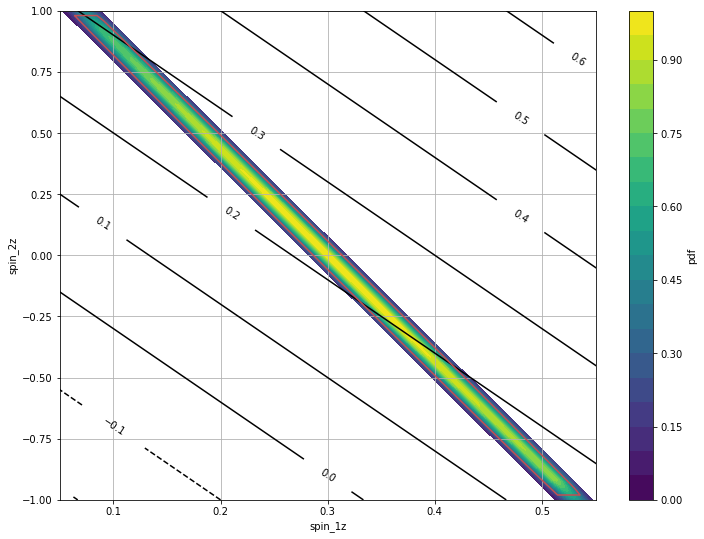

In [14]:
plt.figure(figsize=(12, 9))
plt.contourf(spin_matches.samples[0], spin_matches.samples[1], spin_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(spin_matches.keys()[0])
plt.ylabel(spin_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(spin_ellipse.samples[0], spin_ellipse.samples[1], 'r')
chi_cont = plt.contour(chi1, chi2, chieff, colors='k', levels=np.arange(-1,1,0.1))
plt.clabel(chi_cont, fontsize=10)
plt.xlim([0.05, 0.55])
plt.ylim([-1,1])
plt.grid()
plt.savefig('spin_measurement.png')

## Masses

In [15]:
dx_directions = ['mass_1', 'mass_2']

In [16]:
g_mass = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [17]:
mass_ellipse = g_mass.generate_ellipse()

In [18]:
mass_matches = g_mass.generate_match_grid(npts=21, mismatch=g_mass.mismatch*(1.3)**2)
mass_prob = np.exp(-snr**2/2 * (1 - mass_matches['match']))

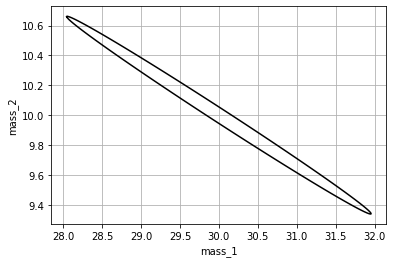

In [19]:
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'k')
plt.xlabel(mass_ellipse.keys()[0])
plt.ylabel(mass_ellipse.keys()[1])
plt.grid()

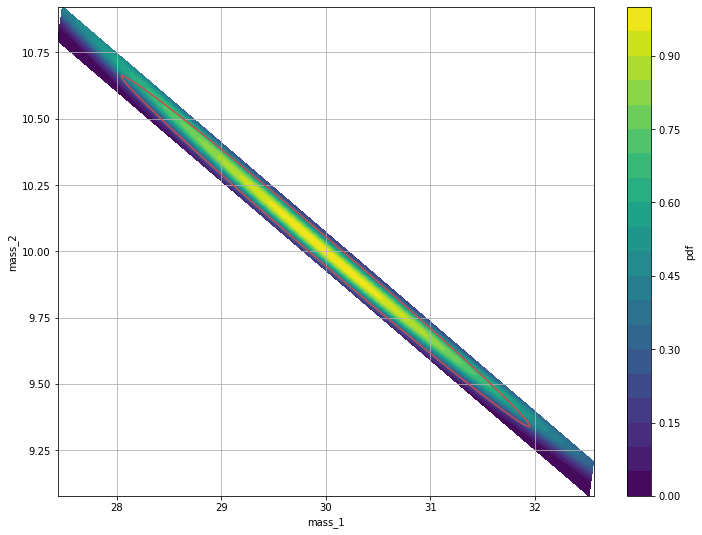

In [20]:
plt.figure(figsize=(12, 9))
plt.contourf(mass_matches.samples[0], mass_matches.samples[1], mass_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mass_matches.keys()[0])
plt.ylabel(mass_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'r')
plt.grid()

### Repeat with chirp mass and eta

In [27]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

In [28]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio']

In [29]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [30]:
mceta_ellipse = g_mceta.generate_ellipse()

In [31]:
mceta_matches = g_mceta.generate_match_grid(npts=21, mismatch=g_mceta.mismatch*(1.3)**2)
mceta_prob = np.exp(-snr**2/2 * (1 - mceta_matches['match']))

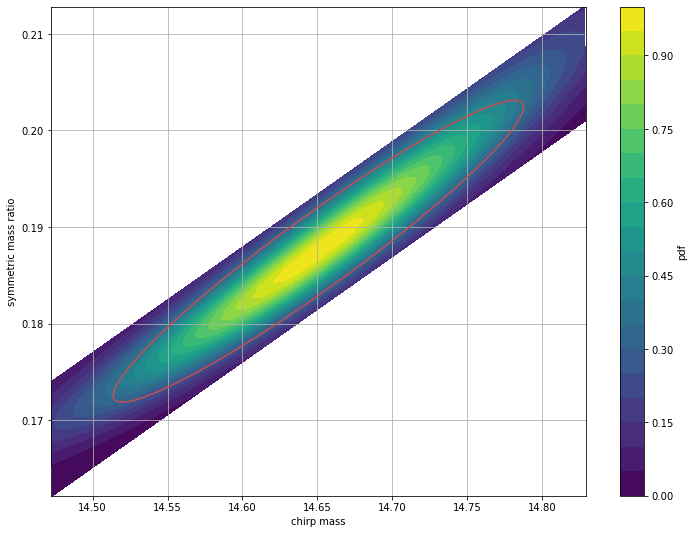

In [32]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_matches.samples[0], mceta_matches.samples[1], mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_matches.keys()[0].replace('_',' '))
plt.ylabel(mceta_matches.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()

In [33]:
mass1 = conversions.mass1_from_mchirp_eta(mceta_matches['chirp_mass'], mceta_matches['symmetric_mass_ratio'])
mass2 = conversions.mass2_from_mchirp_eta(mceta_matches['chirp_mass'], mceta_matches['symmetric_mass_ratio'])

mass1_el = conversions.mass1_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])
mass2_el = conversions.mass2_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])

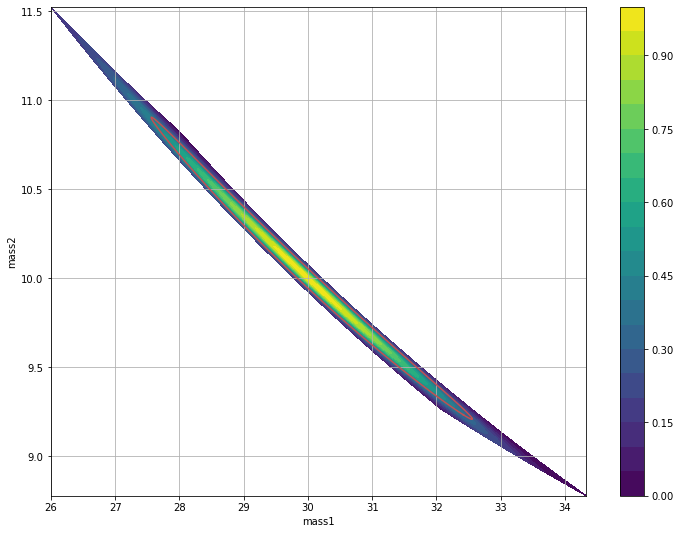

In [34]:
plt.figure(figsize=(12, 9))
plt.contourf(mass1, mass2, mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.plot(mass1_el, mass2_el, 'r')
plt.colorbar()
plt.grid()

## Three dimensions with projection

Note: we are using "chi_eff", but that's just putting the same spin on both BHs, so probably don't need to worry about the fact that it's not the best measured spin direction.

In [35]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff
        }

In [36]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']

In [37]:
g_3d = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

### Chirp mass -- eta

In [38]:
dx_keep = ['chirp_mass','symmetric_mass_ratio']


2d calculation

In [39]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [40]:
mceta_ellipse = mceta_ellipse = g_mceta.generate_ellipse()

mceta_matches = g_mceta.generate_match_grid(npts=21, mismatch=g_mceta.mismatch*(1.3)**2)
mceta_prob = np.exp(-snr**2/2 * (1 - mceta_matches['match']))

3d calculation

In [41]:
g_3d.project_metric(dx_keep)
mceta_3d_ellipse = g_3d.generate_ellipse(projected=True)

mceta_proj_matches = g_3d.generate_match_grid(projected=True, mismatch = g_3d.mismatch * (1.1)**2, npts=21)
mceta_proj_prob = np.exp(-snr**2/2 * (1 - mceta_proj_matches['match']))

Compare regions

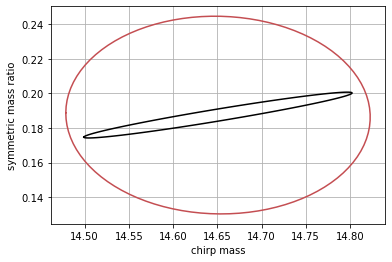

In [42]:
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'k')
plt.plot(mceta_3d_ellipse.samples[0], mceta_3d_ellipse.samples[1], 'r')
plt.xlabel(mceta_3d_ellipse.keys()[0].replace('_',' '))
plt.ylabel(mceta_3d_ellipse.keys()[1].replace('_',' '))
plt.grid()

Check matches

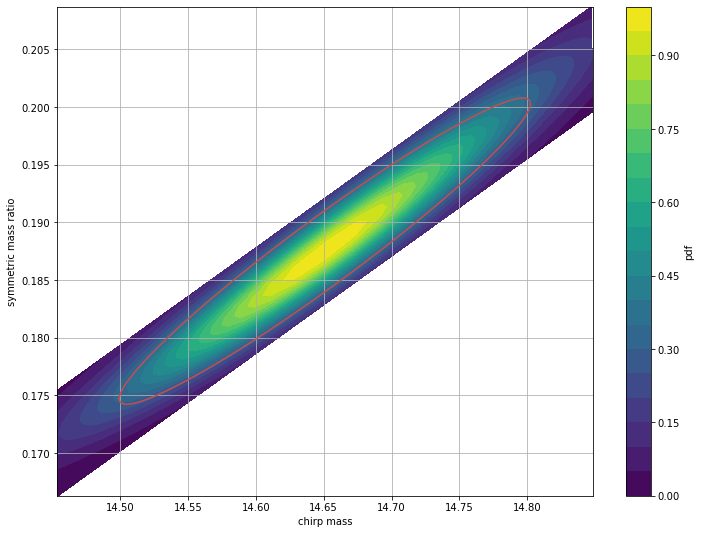

In [43]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_matches.samples[0], mceta_matches.samples[1], mceta_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_matches.keys()[0].replace('_',' '))
plt.ylabel(mceta_matches.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()
plt.savefig('mc_eta_2d_contours.png')

In [44]:
npts = 21

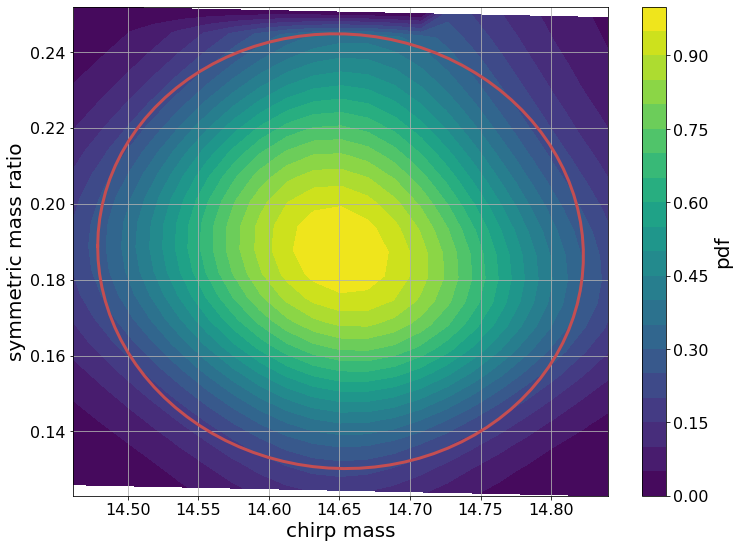

In [66]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_proj_matches.samples[0].reshape([npts,npts]), 
             mceta_proj_matches.samples[1].reshape([npts,npts]), 
             mceta_proj_prob.reshape([npts,npts]), 
             levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_proj_matches.keys()[0].replace('_',' '))
plt.ylabel(mceta_proj_matches.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mceta_3d_ellipse.samples[0], mceta_3d_ellipse.samples[1], 'r', linewidth=3)
plt.grid()
plt.savefig('mc_eta_3d_contours.png')

### eta -- chi eff

In [46]:
dx_keep = ['symmetric_mass_ratio', 'chi_eff']

In [47]:
g_eta_chi = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

eta_chi_ellipse = g_eta_chi.generate_ellipse()

eta_chi_matches = g_eta_chi.generate_match_grid(mismatch = g_eta_chi.mismatch * (1.3)**2, npts=21)
eta_chi_prob = np.exp(-snr**2/2 * (1 - eta_chi_matches['match']))

In [48]:
g_3d.project_metric(dx_keep)
eta_chi_3d_ellipse = g_3d.generate_ellipse(projected=True)

eta_chi_proj_matches = g_3d.generate_match_grid(projected=True, mismatch = g_3d.mismatch * 1.1**2, npts=21)
eta_chi_proj_prob = np.exp(-snr**2/2 * (1 - eta_chi_proj_matches['match']))

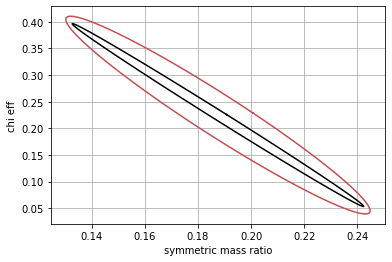

In [49]:
plt.plot(eta_chi_ellipse.samples[0], eta_chi_ellipse.samples[1], 'k')
plt.plot(eta_chi_3d_ellipse.samples[0], eta_chi_3d_ellipse.samples[1], 'r')
plt.xlabel(eta_chi_3d_ellipse.keys()[0].replace('_',' '))
plt.ylabel(eta_chi_3d_ellipse.keys()[1].replace('_',' '))
plt.grid()
plt.savefig('eta_chi_contours.png')

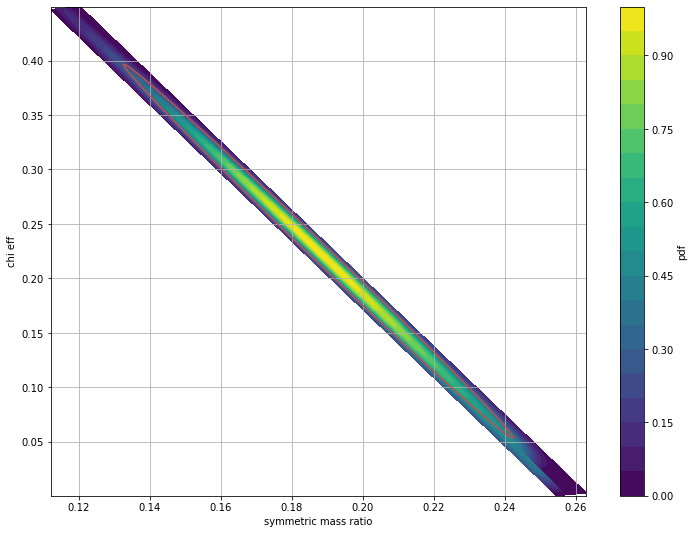

In [50]:
plt.figure(figsize=(12, 9))
plt.contourf(eta_chi_matches.samples[0], eta_chi_matches.samples[1], eta_chi_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(eta_chi_matches.keys()[0].replace('_',' '))
plt.ylabel(eta_chi_matches.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(eta_chi_ellipse.samples[0], eta_chi_ellipse.samples[1], 'r')
plt.grid()

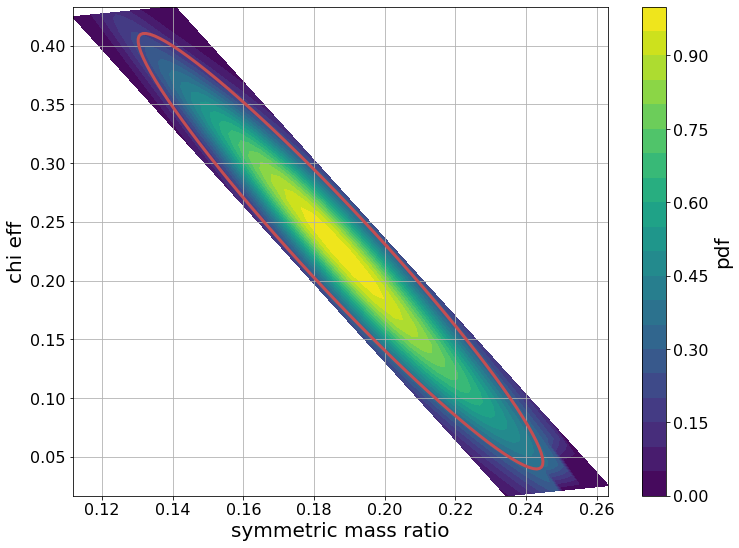

In [68]:
plt.figure(figsize=(12, 9))
plt.contourf(eta_chi_proj_matches.samples[0].reshape([npts,npts]), 
             eta_chi_proj_matches.samples[1].reshape([npts,npts]), 
             eta_chi_proj_prob.reshape([npts,npts]), 
             levels=np.linspace(0, 1, 21))
plt.xlabel(eta_chi_proj_matches.keys()[0].replace('_',' '))
plt.ylabel(eta_chi_proj_matches.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(eta_chi_3d_ellipse.samples[0], eta_chi_3d_ellipse.samples[1], 'r', linewidth=3)
plt.grid()
plt.savefig('eta_chi_3d_contours.png')

### chirp mass -- chi eff

In [52]:
dx_keep = ['chirp_mass', 'chi_eff']

In [53]:
g_mc_chi = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

mc_chi_ellipse = g_mc_chi.generate_ellipse()

mc_chi_matches = g_mc_chi.generate_match_grid(mismatch = g_mc_chi.mismatch * 1.3**2, npts=21)
mc_chi_prob = np.exp(-snr**2/2 * (1 - mc_chi_matches['match']))

In [54]:
g_3d.project_metric(dx_keep)
mc_chi_3d_ellipse = g_3d.generate_ellipse(projected=True)

In [55]:
mc_chi_proj_matches = g_3d.generate_match_grid(projected=True, npts=21)
mc_chi_proj_prob = np.exp(-snr**2/2 * (1 - mc_chi_proj_matches['match']))

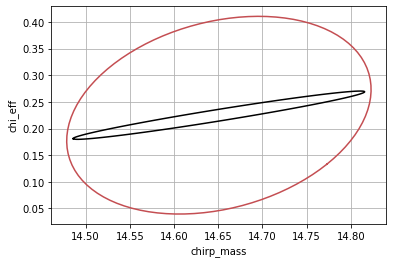

In [56]:
plt.plot(mc_chi_ellipse.samples[0], mc_chi_ellipse.samples[1], 'k')
plt.plot(mc_chi_3d_ellipse.samples[0], mc_chi_3d_ellipse.samples[1], 'r')
plt.xlabel(mc_chi_3d_ellipse.keys()[0])
plt.ylabel(mc_chi_3d_ellipse.keys()[1])
plt.grid()

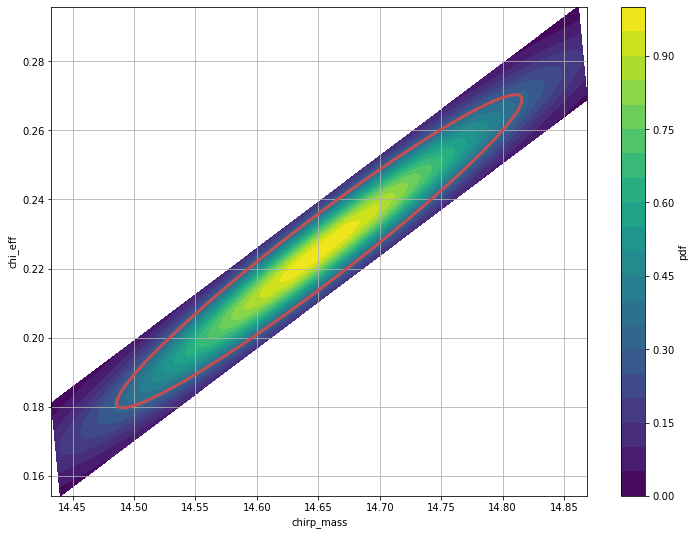

In [61]:
plt.figure(figsize=(12, 9))
plt.contourf(mc_chi_matches.samples[0], mc_chi_matches.samples[1], mc_chi_prob, levels=np.linspace(0, 1, 21))
plt.xlabel(mc_chi_matches.keys()[0])
plt.ylabel(mc_chi_matches.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mc_chi_ellipse.samples[0], mc_chi_ellipse.samples[1], 'r', linewidth=3)
plt.grid()

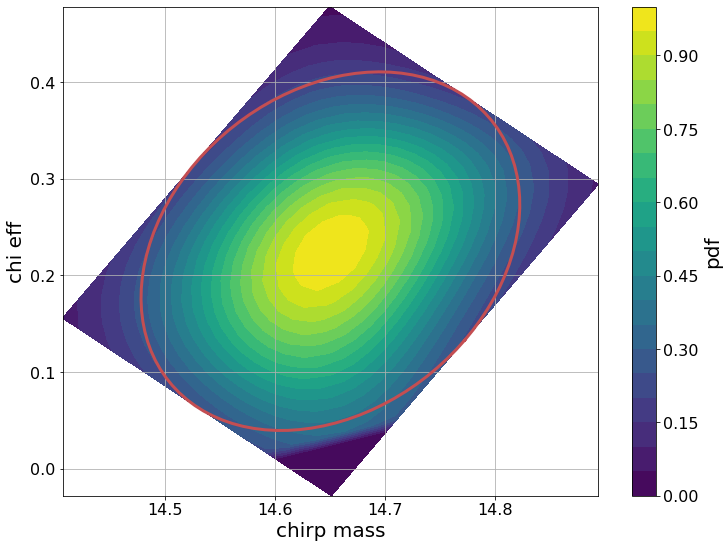

In [69]:
plt.figure(figsize=(12, 9))
plt.contourf(mc_chi_proj_matches.samples[0].reshape([npts,npts]), 
             mc_chi_proj_matches.samples[1].reshape([npts,npts]), 
             mc_chi_proj_prob.reshape([npts,npts]), 
             levels=np.linspace(0, 1, 21))
plt.xlabel(mc_chi_proj_matches.keys()[0].replace('_',' '))
plt.ylabel(mc_chi_proj_matches.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mc_chi_3d_ellipse.samples[0], mc_chi_3d_ellipse.samples[1], 'r', linewidth=3)
plt.grid()
plt.savefig('mc_chi_3d_contours.png')